# **REINFORCE with Differential Privacy on CartPole**
## In this notebook, we adapt DP-SGD to REINFORCE on the Cartpole game.

## Acknowledgement

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl/blob/master/dqn_working.ipynb).



## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
from torch.nn.utils import clip_grad_norm_

import os
import matplotlib.pyplot as plt
import numpy as np
import gym

## Acknowledgement

Code adapted from https://github.com/bentrevett/pytorch-rl

In this notebook we solve the Cartpole game using the REINFORCE algorithm coupled with a MLP.

## Initialize environments

In [ ]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

## Seed

In [ ]:
SEED = 42

train_env.reset(seed=SEED);
test_env.reset(seed=SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

## REINFORCE algorithm

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

## Training

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [ ]:
def evaluate(env, policy):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:     
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_pred = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
       
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        episode_reward += reward
        
    return episode_reward

In [ ]:
def train_with_noise(env, policy, discount_factor, optimizer, max_grad_norm, sigma):
    
    policy.train()
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0
    state, _ = env.reset()
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = policy(state)
        
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
        
    returns = calculate_returns(rewards, discount_factor)
        
    loss = update_policy(returns, log_prob_actions, optimizer, max_grad_norm, sigma)

    return loss, episode_reward

In [ ]:
def update_policy(returns, log_prob_actions, optimizer, max_grad_norm, sigma):
    
    optimizer.zero_grad()
    returns = returns.detach()
    loss = - (returns * log_prob_actions).sum()
    loss.backward()  # Fills p.grad
    # Add noise to the gradients    
    for p in policy.parameters():
        clip_grad_norm_(p, max_grad_norm)
        p.grad += torch.normal(mean=0., std=sigma * max_grad_norm, size=p.size())  # Gaussian noise mechanism
    optimizer.step()

    return loss.item()

## **Experiment** 
Train a policy with various level of noise, and compare sample complexity. >e will adapt our training procedure: we train for a fixed number of episodes.

To obtain robust results, we will run the code 100 times

In [ ]:
total_nb_episodes = 1000
gamma = 0.99
noise_levels = [0., 0.1, 0.2, 0.4, 0.6]
lr = 0.01
n_trials = 25

max_grad_norm = 8

print_every = 25

run_0 = 100
nb_runs = 400

os.makedirs('simulations', exist_ok=True)

for run in range(nb_runs):
    print('Starting run {}: '.format(run))
    train_rewards = np.zeros((len(noise_levels), total_nb_episodes))
    test_rewards = np.zeros((len(noise_levels), total_nb_episodes))

    for i, sigma in enumerate(noise_levels):
        train_env.reset(seed=SEED);
        test_env.reset(seed=SEED+1);

        print("-------------- Noise: sigma = {} ---------------\n".format(sigma))
        policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
        policy.apply(init_weights)

        optimizer = optim.Adam(policy.parameters(), lr=lr)
        convergence = False

        for episode in range(total_nb_episodes):
            if not convergence:
                loss, train_reward = train_with_noise(train_env, policy,
                                                      discount_factor = gamma, optimizer=optimizer,
                                                      max_grad_norm=max_grad_norm, sigma=sigma)
                test_reward = evaluate(test_env, policy)

                train_rewards[i][episode] = train_reward
                test_rewards[i][episode] = test_reward

                mean_train_rewards = np.mean(train_rewards[i][episode-n_trials:episode+1])
                mean_test_rewards = np.mean(test_rewards[i][episode-n_trials:episode+1])

                convergence = (mean_test_rewards) >= 475
                if convergence: print("Achieved convergence")
            else:
                train_rewards[i][episode] = train_rewards[i][episode-1]
                test_rewards[i][episode] = test_rewards[i][episode-1]

            if episode % print_every == 0:
                print(f'| Episode: {episode:3} | Train Reward: {train_reward:5.1f} | Test Reward: {test_reward:5.1f} |')
        
    np.save('rewards_run_{}.npy'.format(run_0 + run), test_rewards)


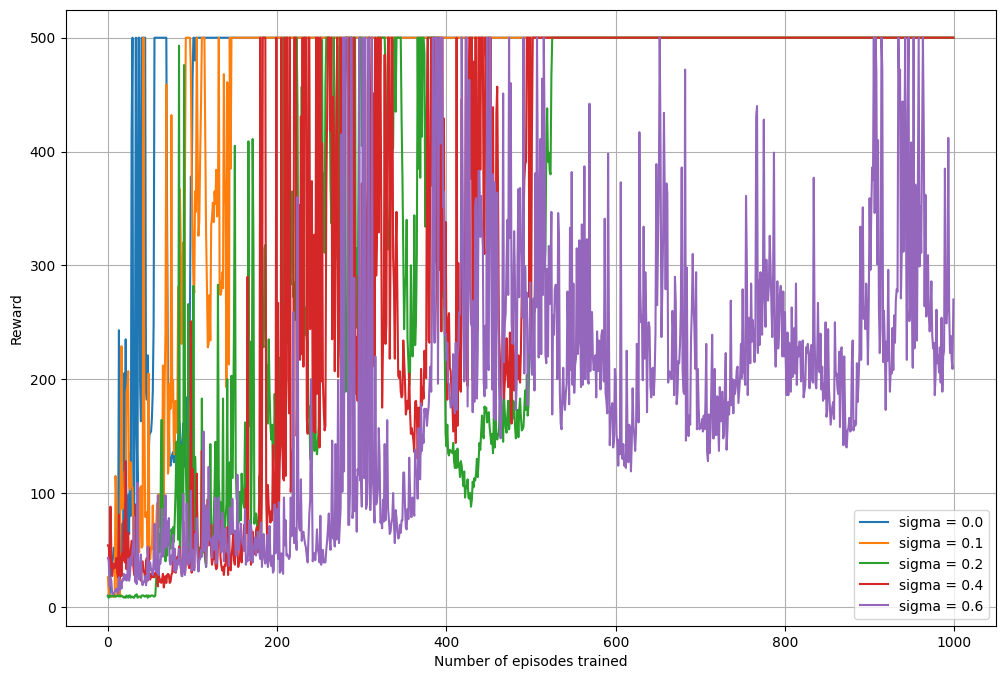

In [ ]:
fig = plt.figure(figsize=(12,8))

for i, sigma in enumerate(noise_levels):
    plt.plot(test_rewards[i], label='sigma = {}'.format(sigma))

plt.xlabel('Number of episodes trained')
plt.ylabel('Reward')

plt.legend()
plt.legend(loc='lower right')
plt.grid()
plt.show()